In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyascore import SpectraParser, PyAscore

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Comparison of the results of pyAscore against Ascore

## 1) Intro

Since pyAscore is a re-implementation of the Ascore algorithm, it is of interest to us to know how well the results of the two algorithms compare to each other. Sadly, the original implementation of Ascore is no longer available. Instead, we turn to data from Huttlin *et al.* (2010) where the original Ascore had been run. We did not re-search the data, but merely run pyAscore using the reported PSMs from a single tissue from the paper.

## 2) Load Huttlin *et al.* (2010) PSM data

We don't need to analyze any more than a single tissue within mouse to get enough PSMs for our comparison, so we will look at the mouse brain data which has the most PSMs. I also want to limit the number of phosphorylation events that we look at, so we will only be analyzing PSMs with at most 2 phosphorylations.

In [2]:
huttlin_scores = pd.read_csv("../Mouse/mouse_atlas_psms.csv")
huttlin_scores = huttlin_scores[huttlin_scores["tissue"] == "Brain"]
huttlin_scores = huttlin_scores[huttlin_scores["# sites"] == 2]
huttlin_scores = huttlin_scores.loc[:, ["Search Name", "ms2_first_scan_number", "z",
                                        "Peptide Sequence (Corrected by Ascore)",  "# sites",
                                        "peptide_score", "ascore_1", "ascore_2"]]
huttlin_scores["Search Name"] = huttlin_scores["Search Name"].str.extract("(o[0-9]{5})")
huttlin_scores.columns = ["sample", "scan", "charge", "peptide", "nphospho", "pepscore", "ascore_1", "ascore_2"]

In [3]:
huttlin_scores["peptide"] = huttlin_scores["peptide"].str.replace("M#", "M[16]", regex=True)
huttlin_scores["peptide"] = huttlin_scores["peptide"].str.replace("([STY])\*", r"\1[80]", regex=True)

## 3) Compare versions of Ascore

### 3.1) Run pyAscore on Huttlin PSMs

In [4]:
def transform_sequence(seq):
    stripped_sequence = re.sub("[^A-Z]", "", seq)
    tokenized_seq = re.findall("[A-Z][^A-Z]*", seq)
    
    # Fix masses
    mod_pos = []
    mod_mass = []
    for pos, aa in enumerate(tokenized_seq, 1):
        mass_search = re.search("[0-9]+", aa)
        if mass_search is not None:
            mod_pos.append(pos)
            mod_mass.append(
                {"16" : 15.9949,
                 "80" : 79.966331}[mass_search.group()]
            )
    mod_pos, mod_mass = np.array(mod_pos), np.array(mod_mass)
    
    # Get info
    phos_select = np.isclose(mod_mass, 79.966331)
    nphos = np.sum(phos_select)
    aux_mod_pos = mod_pos[~phos_select].astype(np.uint32)
    aux_mod_mass = mod_mass[~phos_select].astype(np.float32)

    result = {"peptide" : stripped_sequence,
              "nphos" : nphos,
              "aux_mod_pos" : np.array(aux_mod_pos, dtype=np.uint32),
              "aux_mod_mass" : np.array(aux_mod_mass, dtype=np.float32)}
    
    return result

In [5]:
spectra = {}
for sample in huttlin_scores["sample"].unique():
    file_path = "../Mouse/" + sample + ".mzML"
    spectra[sample] = SpectraParser(file_path, "mzML").to_dict()

In [13]:
mod_mass = 79.966331
ascore = PyAscore(bin_size=100., n_top=10,
                  mod_group="STY",
                  mod_mass=mod_mass,
                  mz_error=.6)

pyascore_scores = huttlin_scores.copy()
pyascore_scores["ascore_1"] = 0.
pyascore_scores["ascore_2"] = np.nan
for ind in range(pyascore_scores.shape[0]):
    psm = pyascore_scores.iloc[ind]
    spectrum = spectra[psm["sample"]][psm["scan"]]
    peptide_info = transform_sequence(psm["peptide"])
    
    ascore.score(mz_arr = spectrum["mz_values"],
                 int_arr = spectrum["intensity_values"],
                 peptide = peptide_info["peptide"],
                 n_of_mod = peptide_info["nphos"],
                 max_fragment_charge = psm["charge"] - 1,
                 aux_mod_pos = peptide_info["aux_mod_pos"],
                 aux_mod_mass = peptide_info["aux_mod_mass"])
    
    pyascore_scores["peptide"].values[ind] = ascore.best_sequence
    pyascore_scores["pepscore"].values[ind] = ascore.best_score
    
    for score_ind, value in enumerate(ascore.ascores, 1):
        pyascore_scores[f"ascore_{score_ind}"].values[ind] = value

### 3.2) Compare outputs

In [14]:
huttlin_scores["max_ascore"] = huttlin_scores.loc[:, ["ascore_1", "ascore_2"]].apply(max, axis=1)
huttlin_scores["min_ascore"] = huttlin_scores.loc[:, ["ascore_1", "ascore_2"]].apply(min, axis=1)

pyascore_scores["max_ascore"] = pyascore_scores.loc[:, ["ascore_1", "ascore_2"]].apply(max, axis=1)
pyascore_scores["min_ascore"] = pyascore_scores.loc[:, ["ascore_1", "ascore_2"]].apply(min, axis=1)

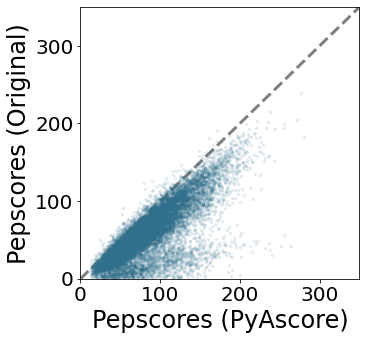

In [15]:
plt.figure(figsize=[5, 5])

plt.plot([0, 350], [0, 350],
         color="black",
         alpha=.5,
         linestyle="--",
         lw=3,
         zorder=-1)

plt.scatter(huttlin_scores.pepscore,
            pyascore_scores.pepscore,
            color="#30708d",
            s=5,
            alpha=.1)

plt.xlim(0, 350)
plt.ylim(0, 350)

plt.xlabel("Pepscores (PyAscore)", size=24)
plt.ylabel("Pepscores (Original)", size=24)
plt.tick_params(labelsize=20)

plt.show()

In [16]:
def find_phospho_pos(seq, n):
    tokenized_seq = re.findall("[A-Z][^A-Z]*", seq)
    count = 0
    for pos, aa in enumerate(tokenized_seq, 1):
        if "80" in aa:
            count += 1
            
        if count == n:
            return pos
        
    return -1

In [17]:
huttlin_scores["ascore_1_pos"] = huttlin_scores["peptide"].apply(find_phospho_pos, n=1)
huttlin_scores["ascore_2_pos"] = huttlin_scores["peptide"].apply(find_phospho_pos, n=2)

huttlin_long = pd.concat([
    huttlin_scores.loc[:, ["sample", "scan", "ascore_1_pos", "ascore_1"]]\
                  .rename({"ascore_1_pos" : "pos",
                           "ascore_1" : "ascore"},
                          axis=1),
    huttlin_scores.loc[:, ["sample", "scan", "ascore_2_pos", "ascore_2"]]\
                  .rename({"ascore_2_pos" : "pos",
                           "ascore_2" : "ascore"},
                          axis=1)
])
huttlin_long = huttlin_long[~np.isnan(huttlin_long["ascore"])]

pyascore_scores["ascore_1_pos"] = pyascore_scores["peptide"].apply(find_phospho_pos, n=1)
pyascore_scores["ascore_2_pos"] = pyascore_scores["peptide"].apply(find_phospho_pos, n=2)

pyascore_long = pd.concat([
    pyascore_scores.loc[:, ["sample", "scan", "ascore_1_pos", "ascore_1"]]\
                   .rename({"ascore_1_pos" : "pos",
                            "ascore_1" : "ascore"},
                           axis=1),
    pyascore_scores.loc[:, ["sample", "scan", "ascore_2_pos", "ascore_2"]]\
                   .rename({"ascore_2_pos" : "pos",
                            "ascore_2" : "ascore"},
                           axis=1)
])
pyascore_long = pyascore_long[~np.isnan(pyascore_long["ascore"])]

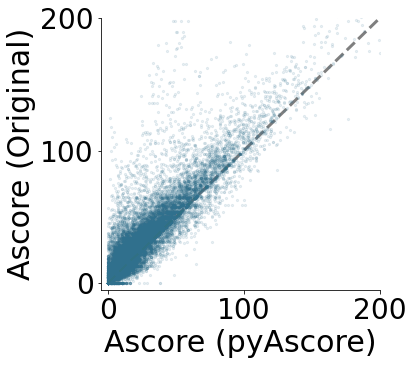

In [18]:
combined_scores = huttlin_long.set_index(["sample", "scan", "pos"])\
                              .join(pyascore_long.set_index(["sample", "scan", "pos"]),
                                    how="inner",
                                    rsuffix="_pyascore",
                                    lsuffix="_huttlin")

plt.figure(figsize=[5, 5])

plt.plot([0, 350], [0, 350],
         color="black",
         alpha=.5,
         linestyle="--",
         lw=3,
         zorder=-1)

plt.scatter(combined_scores.ascore_pyascore,
            combined_scores.ascore_huttlin,
            color="#30708d",
            s=5,
            alpha=.1)

plt.xlim(-5, 200)
plt.ylim(-5, 200)

plt.xlabel("Ascore (pyAscore)", size=30)
plt.ylabel("Ascore (Original)", size=30)
plt.tick_params(labelsize=28)
sns.despine()

plt.savefig("figures/pyascore_ascore_comparison_scatter.svg",
            bbox_inches="tight",
            facecolor="white")
plt.savefig("figures/pyascore_ascore_comparison_scatter.png",
            dpi=600,
            bbox_inches="tight",
            facecolor="white")
plt.show()

The difficult part about interpretting the above plots is the fact that we cannot see the individual parameter choices of the original algorithm. This can cause large distortions in the correlations since the Ascore is the -log10 of a p-value. It would be better to look at the agreement in the final outputed sequence at a series of relevant thresholds.

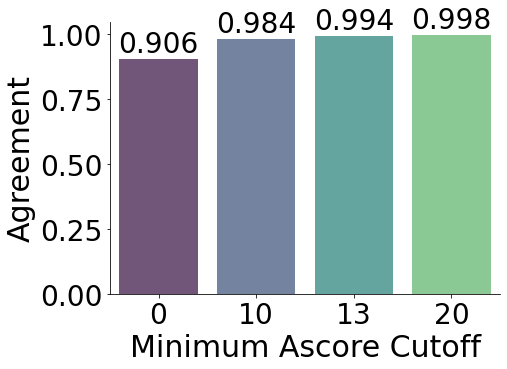

In [19]:
agreement = []
for cutoff in [0, 10, 13, 20]:
    select = np.logical_and(huttlin_scores.min_ascore > cutoff,
                            pyascore_scores.min_ascore > cutoff)
    huttlin_peptides = huttlin_scores[select].peptide
    pyascore_peptides = pyascore_scores[select].peptide
    agreement.append(
        {"cutoff" : str(cutoff),
         "agreement" : np.sum(huttlin_peptides == pyascore_peptides)/np.sum(select)}
    )
agreement = pd.DataFrame.from_records(agreement)

plt.figure(figsize=[7, 5])

sns.barplot(data=agreement,
            x="cutoff",
            y="agreement",
            palette=["#461554", "#3c568b", "#23958a", "#56c566"],
            alpha=.75)

for x, y in enumerate(agreement.agreement):
    plt.text(x=x,
             y=y + .025,
             s=f"{y:.3f}",
             ha="center",
             size=28)
plt.yticks([0, .25, .5, .75, 1])    
plt.xlabel("Minimum Ascore Cutoff", size=30)
plt.ylabel("Agreement", size=30)
plt.tick_params(labelsize=28)
sns.despine()

plt.savefig("figures/pyascore_ascore_comparison_barplot.svg",
            bbox_inches="tight",
            facecolor="white")
plt.show()

This is more in line with what we would expect. Even if the individual Ascores are off, the final outputed sequences are nearly identicle when there is sufficient information in the system. Thus, the two algorithms can likely be used as drop in replacements for each other.